In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Sample candlestick data (replace with real data)
# df = pd.read_csv("your_ohlcv_data.csv")
# Sample: open, high, low, close, volume
# df = pd.DataFrame({
#     'open': np.random.uniform(100, 110, 500),
#     'high': np.random.uniform(110, 115, 500),
#     'low': np.random.uniform(95, 100, 500),
#     'close': np.random.uniform(100, 110, 500),
#     'volume': np.random.randint(1000, 10000, 500)
# })


In [ ]:

from tvDatafeed import TvDatafeed,Interval


tv = TvDatafeed()
nifty_data=tv.get_hist('NIFTY','NSE',interval=Interval.in_5_minute,n_bars=5000)


In [ ]:
df = nifty_data.copy()

In [ ]:
df=df.tail(500)

In [ ]:

# Feature engineering
df['body_size'] = abs(df['close'] - df['open'])
df['top_wick'] = df['high'] - df[['close', 'open']].max(axis=1)
df['bottom_wick'] = df[['close', 'open']].min(axis=1) - df['low']
df['rvol'] = df['volume'] / df['volume'].rolling(window=20).mean()

# Drop initial NaNs
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Parameters
window_size = 20
feature_cols = ['body_size', 'top_wick', 'bottom_wick', 'rvol']
X = []
y = []

# Rolling window generation
for i in range(window_size, len(df) - 1):
    window_features = []
    for j in range(window_size):
        candle_features = df.loc[i - window_size + j, feature_cols].values
        window_features.extend(candle_features)
    X.append(window_features)
    target = int(df.loc[i + 1, 'close'] > df.loc[i + 1, 'open'])  # next candle bullish?
    y.append(target)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
import matplotlib.pyplot as plt

# Get aligned indices (test starts after train)
start_idx = window_size + len(X_train)
end_idx = start_idx + len(X_test)

# Create a subset of the original dataframe for plotting
df_plot = df.iloc[start_idx:end_idx].copy()
df_plot['pred'] = y_pred
df_plot['actual'] = y_test

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_plot.index, df_plot['close'], label='Close Price', color='black')

# Mark predicted bullish candles
bullish_preds = df_plot[df_plot['pred'] == 1]
plt.scatter(bullish_preds.index, bullish_preds['close'], label='Predicted Bullish', color='green', marker='^')

# Mark predicted bearish candles
bearish_preds = df_plot[df_plot['pred'] == 0]
plt.scatter(bearish_preds.index, bearish_preds['close'], label='Predicted Bearish', color='red', marker='v')

plt.title("Model Predictions on Candlestick Data")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_plot['correct'] = (df_plot['pred'] == df_plot['actual']).astype(int)
df_plot['cumulative_accuracy'] = df_plot['correct'].expanding().mean()

plt.figure(figsize=(12, 4))
plt.plot(df_plot['cumulative_accuracy'], label='Cumulative Accuracy')
plt.ylim(0, 1)
plt.title("Cumulative Prediction Accuracy Over Time")
plt.xlabel("Time Index")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import ta

# Cell 2: Load or Simulate Data
# Simulate 5-min OHLCV data
# np.random.seed(42)
# df = pd.DataFrame({
#     'open': np.random.uniform(100, 110, 1000),
#     'high': np.random.uniform(110, 115, 1000),
#     'low': np.random.uniform(95, 100, 1000),
#     'close': np.random.uniform(100, 110, 1000),
#     'volume': np.random.randint(1000, 10000, 1000)
# })

df = nifty_data.copy()
df = df.tail(2000)
# Cell 3: Feature Engineering - Candle Features
df['body_size'] = abs(df['close'] - df['open'])
df['top_wick'] = df['high'] - df[['close', 'open']].max(axis=1)
df['bottom_wick'] = df[['close', 'open']].min(axis=1) - df['low']

# Cell 4: Technical Indicators using `ta`
df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['ema_20'] = ta.trend.EMAIndicator(df['close'], window=20).ema_indicator()
df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
df['rvol'] = df['volume'] / df['volume'].rolling(window=20).mean()

# Cell 5: Directional Target Labeling
future_shift = 3  # predict 3 candles ahead
threshold = 0.002  # 0.2% price move
df['future_return'] = df['close'].shift(-future_shift) / df['close'] - 1
df['target'] = df['future_return'].apply(lambda x: 1 if x > threshold else (0 if x < -threshold else np.nan))
df.dropna(inplace=True)

# Cell 6: Prepare Features and Labels
feature_cols = ['body_size', 'top_wick', 'bottom_wick', 'rsi', 'ema_20', 'atr', 'rvol']
X = df[feature_cols]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Cell 7: Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Cell 8: Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cell 9: Plot Price and Predictions
df_test = df.iloc[len(X_train):].copy()
df_test['pred'] = y_pred




ValueError: x and y must be the same size

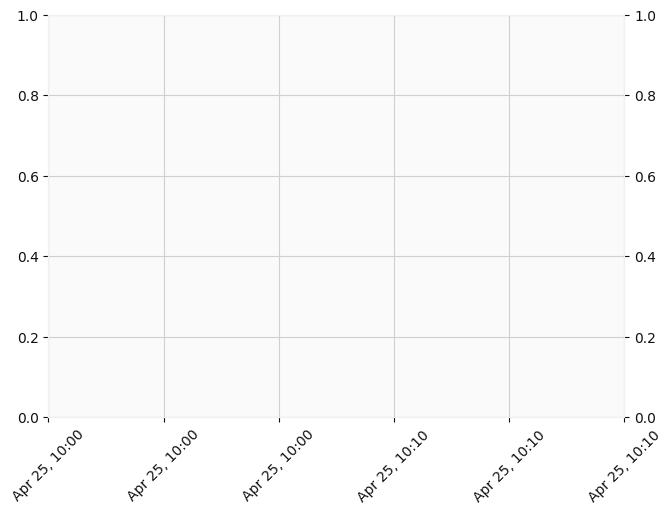

In [35]:
# Cell 9: Plot Price and Predictions (Skip Empty Time Periods)
# df_test = df.iloc[len(X_train):].copy()  # Slice the test data
# df_test['pred'] = y_pred

# # Filter out rows where there's no valid price data (after-market hours or gaps)
# df_test = df_test[df_test['close'].notna()]

# # Ensure predictions align with actual data timestamps (skip empty periods)
# plt.figure(figsize=(14, 6))

# # Plot the Close Price
# plt.plot(df_test.index, df_test['close'].values, label='Close Price', color='black')

# # Plot Bullish predictions (pred = 1)
# bullish_preds = df_test[df_test['pred'] == 1]
# plt.scatter(bullish_preds.index, bullish_preds['close'], color='green', label='Bullish Signal', marker='^')

# # Plot Bearish predictions (pred = 0)
# bearish_preds = df_test[df_test['pred'] == 0]
# plt.scatter(bearish_preds.index, bearish_preds['close'], color='red', label='Bearish Signal', marker='v')

# plt.legend()
# plt.title("Predicted Signals on Price Chart (Skip Empty Periods)")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# Cell 9: Plot Candlestick Chart with Predictions (No Gaps)
import mplfinance as mpf

# Ensure df_test has valid data, no gaps
df_test = df.iloc[len(X_train):].copy()
df_test['pred'] = y_pred
# Filter out rows where there's no valid price data (after-market hours or gaps)
df_test = df_test[df_test['close'].notna()]

# Filter only for active trading hours (if you haven't done it earlier)
# df_test = df_test.between_time('09:30', '16:00')  # Adjust to the market hours of interest

# Create bullish and bearish predictions as markers
bullish_preds = df_test[df_test['pred'] == 1]
bearish_preds = df_test[df_test['pred'] == 0]

# Create signals to plot (markers for predictions)
bullish_markers = mpf.make_addplot(bullish_preds['close'], type='scatter', markersize=100, color='green', marker='^')
bearish_markers = mpf.make_addplot(bearish_preds['close'], type='scatter', markersize=100, color='red', marker='v')

# Customize style (optional)
style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'figure.figsize': (12, 8)})

# Plot the candlestick chart with additional prediction markers
mpf.plot(df_test, type='candle', style=style, title="Candlestick Chart with Predictions", ylabel="Price",
         addplot=[bullish_markers, bearish_markers], ylabel_lower="Volume")



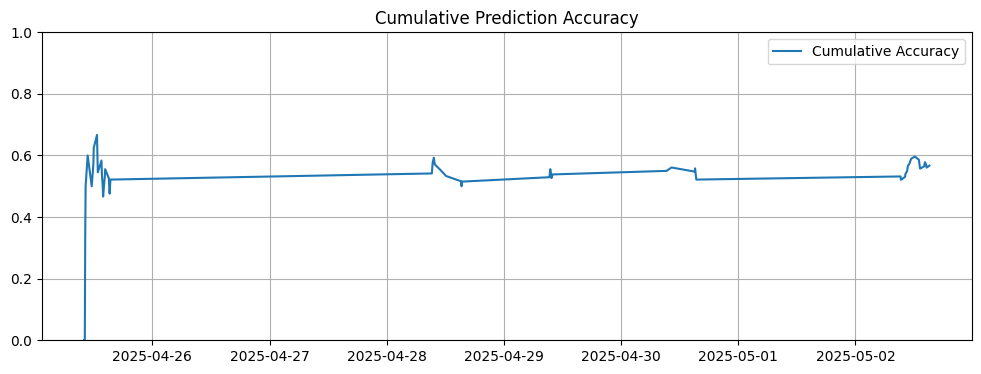

In [29]:


# # Get aligned indices (test starts after train)
# start_idx = window_size + len(X_train)
# end_idx = start_idx + len(X_test)

# # Create a subset of the original dataframe for plotting
# df_plot = df.iloc[start_idx:end_idx].copy()
# df_plot['pred'] = y_pred
# df_plot['actual'] = y_test

# # Plot
# plt.figure(figsize=(14, 6))
# plt.plot(df_plot.index, df_plot['close'], label='Close Price', color='black')

# # Mark predicted bullish candles
# bullish_preds = df_plot[df_plot['pred'] == 1]
# plt.scatter(bullish_preds.index, bullish_preds['close'], label='Predicted Bullish', color='green', marker='^')

# # Mark predicted bearish candles
# bearish_preds = df_plot[df_plot['pred'] == 0]
# plt.scatter(bearish_preds.index, bearish_preds['close'], label='Predicted Bearish', color='red', marker='v')

# plt.title("Model Predictions on Candlestick Data")
# plt.xlabel("Time Index")
# plt.ylabel("Price")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()





# Cell 10: Optional - Cumulative Accuracy
df_test['correct'] = (df_test['pred'] == df_test['target']).astype(int)
df_test['cumulative_accuracy'] = df_test['correct'].expanding().mean()

plt.figure(figsize=(12, 4))
plt.plot(df_test['cumulative_accuracy'], label='Cumulative Accuracy')
plt.title("Cumulative Prediction Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


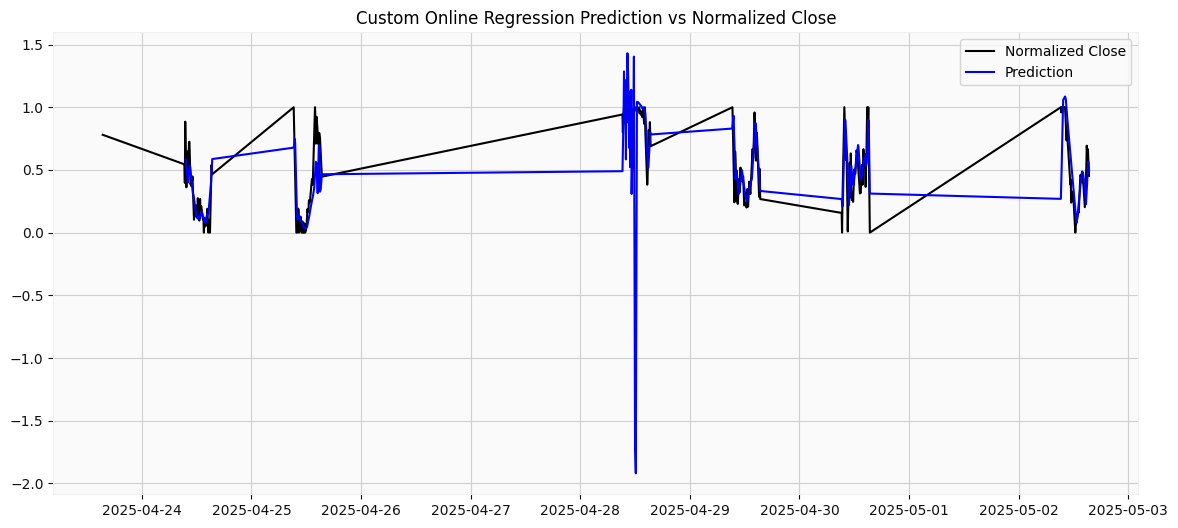

In [ ]:
import pandas as pd
import numpy as np

# Simulated OHLCV data

df = nifty_data.copy()

df = df.tail(500)
# Parameters
len_window = 50
learning_rate = 0.1
smooth = True
smooth_len = 5

# Initial Coefficients
b = {
    'close': 0.5,
    'open': 0.4,
    'high': 0.35,
    'low': 0.25,
    'volume': 0.3  # added volume
}

# Normalize function (min-max)
def normalize(series, window):
    return (series - series.rolling(window).min()) / (series.rolling(window).max() - series.rolling(window).min())

# Normalize input data
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[f'n_{col}'] = normalize(df[col], len_window)

# Initialize prediction and error series
df['prediction'] = np.nan
df['error'] = np.nan

# Run the model
for i in range(len_window, len(df)):
    row = df.iloc[i]

    # Weighted nonlinear regression prediction
    x = {key: df[f'n_{key}'].iloc[i] for key in b.keys()}
    
    # Normalize weights
    b_sum = sum(b.values())
    weights = {k: v / b_sum for k, v in b.items()}

    prediction = sum(weights[k] * x[k] for k in x)

    actual = df['n_close'].iloc[i]
    error = actual - prediction

    # Store results
    df.loc[df.index[i], 'prediction'] = prediction
    df.loc[df.index[i], 'error'] = error

    # Gradient descent update
    for k in b.keys():
        b[k] = b[k] - learning_rate * error * x[k]

# Optional smoothing
if smooth:
    df['smoothed_pred'] = df['prediction'].rolling(smooth_len).mean()
else:
    df['smoothed_pred'] = df['prediction']

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df['n_close'], label='Normalized Close', color='black')
plt.plot(df['smoothed_pred'], label='Prediction', color='blue')
plt.title("Custom Online Regression Prediction vs Normalized Close")
plt.legend()
plt.grid(True)
plt.show()



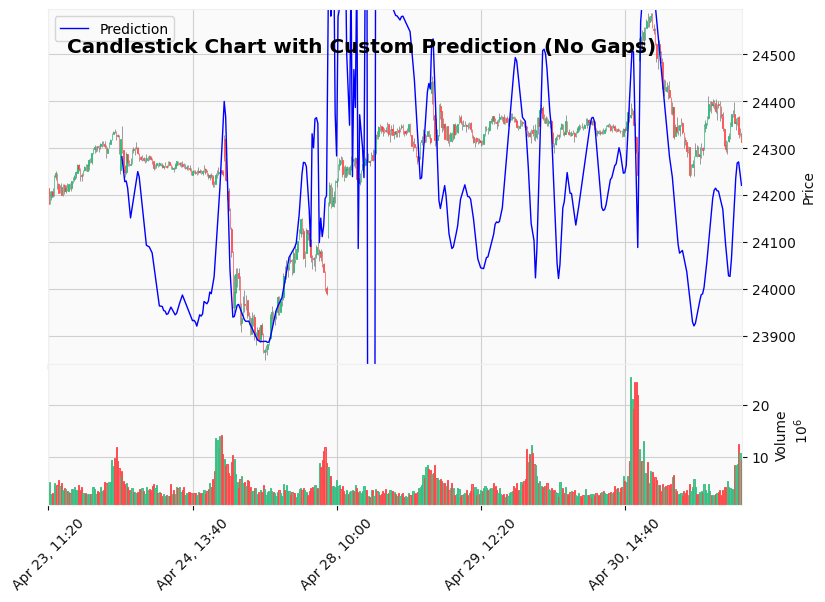

In [38]:

import mplfinance as mpf
import pandas as pd


# Assumption: df already has 'open', 'high', 'low', 'close', 'volume' and 'smoothed_pred'
# Make sure index is datetime and filtered for trading hours only
df_filtered = df.copy()

# OPTIONAL: Filter for regular session only (9:30 to 16:00)
df_filtered = df_filtered.between_time('09:30', '16:00')

# Example scaling (optional)
price_range = df_filtered['close'].max() - df_filtered['close'].min()
df_filtered['scaled_pred'] = df_filtered['smoothed_pred'] * price_range + df_filtered['close'].min()

# Create line plot of prediction as overlay
pred_line = mpf.make_addplot(df_filtered['scaled_pred'], color='blue', width=1, panel=0, label='Prediction')

# Candlestick chart with prediction line, no gaps
mpf.plot(df_filtered,
         type='candle',
         volume=True,
         style='yahoo',
         title='Candlestick Chart with Custom Prediction (No Gaps)',
         ylabel='Price',
         ylabel_lower='Volume',
         addplot=[pred_line],
         tight_layout=True,
         returnfig=False)

d:\py_code_workspace\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:30:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ValueError: x and y must be the same size

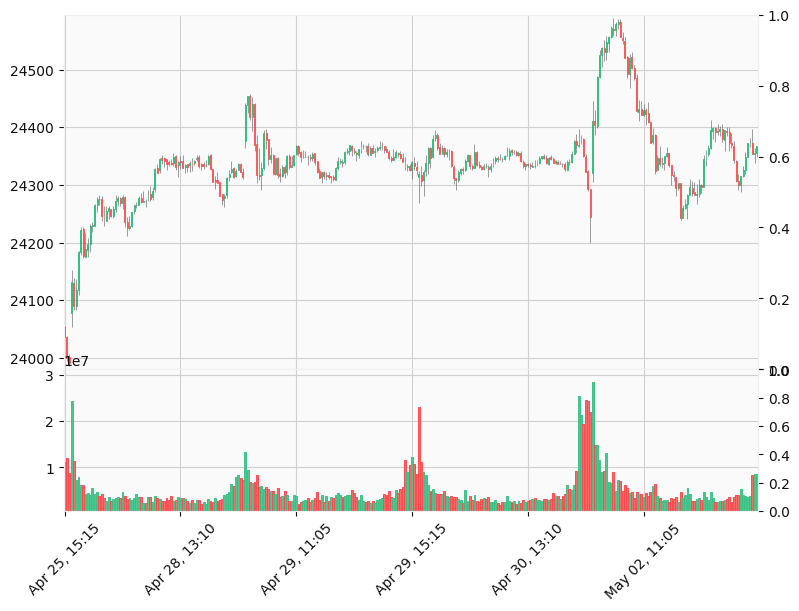

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import mplfinance as mpf

# Simulate OHLCV data
# np.random.seed(42)
# n = 1000
# df = pd.DataFrame({
#     'open': np.random.uniform(100, 110, n),
#     'high': np.random.uniform(110, 115, n),
#     'low': np.random.uniform(95, 100, n),
#     'close': np.random.uniform(100, 110, n),
#     'volume': np.random.randint(1000, 10000, n)
# })

# df.index = pd.date_range(start='2024-01-01', periods=n, freq='5min')

df = nifty_data.copy()

df = df.tail(1000)
df = df.between_time('09:10', '16:00')  # Filter trading hours

# Normalize features
window = 50
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[f'n_{col}'] = (df[col] - df[col].rolling(window).min()) / (df[col].rolling(window).max() - df[col].rolling(window).min())

# Label future 20-point move
def label_next_20pt_move(close_series, threshold=20):
    labels = []
    future_window = 50
    for i in range(len(close_series)):
        base = close_series.iloc[i]
        label = np.nan
        for j in range(i+1, min(i+future_window, len(close_series))):
            delta = close_series.iloc[j] - base
            if delta >= threshold:
                label = 1
                break
            elif delta <= -threshold:
                label = 0
                break
        labels.append(label)
    return labels

df['move_label'] = label_next_20pt_move(df['close'], threshold=20)
df = df.dropna(subset=['move_label'])

# Train model
features = ['n_open', 'n_high', 'n_low', 'n_close', 'n_volume']
X = df[features]
y = df['move_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict with confidence
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_proba > 0.6, 1, np.where(y_proba < 0.4, 0, -1))

# Evaluate
mask = y_pred != -1
accuracy = (y_pred[mask] == y_test[mask]).mean()
coverage = mask.mean()

# Add predictions to DataFrame
plot_df = df.iloc[len(X_train):].copy()
plot_df['pred'] = y_pred
plot_df = plot_df[plot_df['pred'] != -1]

# Plot signals
bullish = plot_df[plot_df['pred'] == 1]
bearish = plot_df[plot_df['pred'] == 0]

addplots = []
if not bullish.empty:
    addplots.append(mpf.make_addplot(bullish['close'], type='scatter', markersize=100, marker='^', color='green'))
if not bearish.empty:
    addplots.append(mpf.make_addplot(bearish['close'], type='scatter', markersize=100, marker='v', color='red'))

mpf.plot(df.iloc[len(X_train):], type='candle', volume=True, style='yahoo',
         title=f'Next 20-Point Move Prediction (Accuracy: {accuracy:.2%}, Coverage: {coverage:.2%})',
         ylabel='Price', ylabel_lower='Volume', addplot=addplots, tight_layout=True)


ValueError: x and y must be the same size

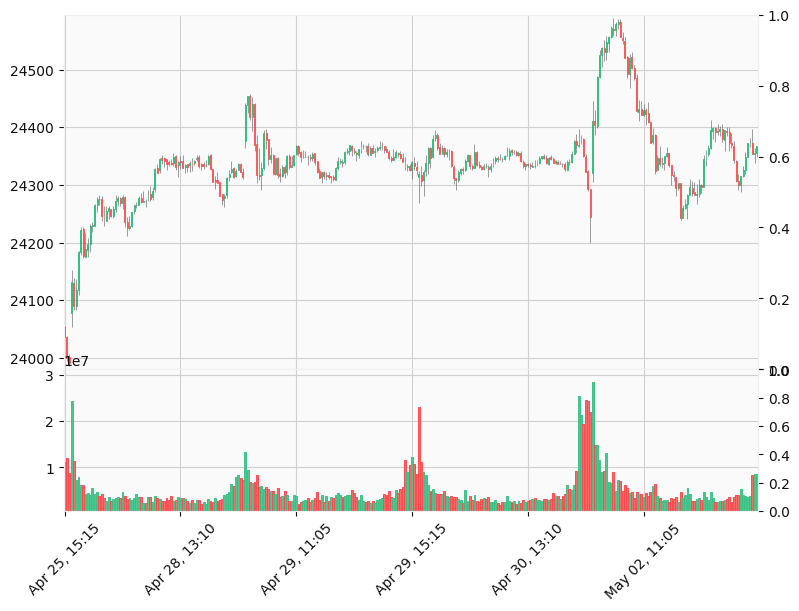

In [45]:
# Use full test set for plotting
plot_base = df.iloc[len(X_train):].copy()
plot_base['pred'] = y_pred
plot_base['pred'] = plot_base['pred'].replace(-1, np.nan)  # Keep full DataFrame, but mask unconfident predictions

# Marker positions
bullish = plot_base[plot_base['pred'] == 1]
bearish = plot_base[plot_base['pred'] == 0]

# # Create addplots
addplots = []
if not bullish.empty:
    addplots.append(mpf.make_addplot(bullish['close'], type='scatter', markersize=100, marker='^', color='green'))
if not bearish.empty:
    addplots.append(mpf.make_addplot(bearish['close'], type='scatter', markersize=100, marker='v', color='red'))

# Plot full test set candles with properly aligned predictions
mpf.plot(plot_base, type='candle', volume=True, style='yahoo',
         title=f'Next 20-Point Move Prediction (Accuracy: {accuracy:.2%}, Coverage: {coverage:.2%})',
         ylabel='Price', ylabel_lower='Volume', addplot=addplots, tight_layout=True)


In [49]:

# Use full test data for plotting
plot_base = df.iloc[len(X_train):].copy()

# Fill pred column with NaN where no prediction made
plot_base['pred'] = -1
plot_base.loc[plot_base.index[:len(y_pred)], 'pred'] = y_pred
plot_base['pred'] = plot_base['pred'].replace(-1, np.nan)

# Extract marker positions
bullish = plot_base[plot_base['pred'] == 1]
bearish = plot_base[plot_base['pred'] == 0]
plot_base.tail()

,symbol,open,high,low,close,volume,n_open,n_high,n_low,n_close,n_volume,move_label,pred
datetime,,,,,,,,,,,,,
2025-05-02 14:50:00,NSE:NIFTY,24348.05,24372.65,24347.55,24372.40,3713689.0,0.407443,0.442857,0.448765,0.532334,0.309124,0.0,1.0
2025-05-02 14:55:00,NSE:NIFTY,24371.65,24381.80,24366.30,24373.95,3744729.0,0.534156,0.512470,0.681782,0.693263,0.316856,0.0,0.0
2025-05-02 15:00:00,NSE:NIFTY,24373.40,24397.75,24354.25,24354.25,8435101.0,0.692915,0.724952,0.632168,0.589168,1.000000,0.0,NaN
2025-05-02 15:05:00,NSE:NIFTY,24353.95,24363.60,24338.15,24354.95,8472780.0,0.590466,0.545100,0.544238,0.600482,1.000000,0.0,0.0
2025-05-02 15:10:00,NSE:NIFTY,24354.85,24367.15,24348.40,24367.15,8645618.0,0.601064,0.572033,0.606680,0.665775,1.000000,0.0,0.0
